# Loading Library
---

## Testing Cuda

In [1]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

True
NVIDIA GeForce RTX 3060


## Loading Bert and Tokenizer

In [ ]:
from transformers import BertModel, BertTokenizer

In [3]:
BERT_PATH = './bert_base_chinese'

bert = BertModel.from_pretrained(BERT_PATH)
tokenizer = BertTokenizer.from_pretrained(BERT_PATH)

tesing BertTokenizer

In [4]:
tokenizer.tokenize("我是孩子王")

['我', '是', '孩', '子', '王']

# Data Preprocessing
---

## Loading Data

In [4]:
import pandas as pd 
import numpy as np

In [19]:
df = pd.read_csv('./data/train_data.csv')
df.head()._append(df.tail())

,Text,Generated
0,3.2题目代码（带注释）4.ProblemD:Xcubic4.1题目分析与题目4类似，但这里...,0
1,而加窗则是为了减少频谱分析时产生的能量泄露，选用汉明窗是因为它可以更好地保留原语音信号的频谱...,0
2,叶绿素荧光参数更多时候体现了光合作用的内在变化，近年来很多研究发现植物光和效率与光强、二氧化...,0
3,在人工智能的训练过程中，数据的质量和可信度是至关重要的，而区块链的去中心化特性有助于避免数据...,1
4,-对于POST方法，接收并处理请求体中的数据，并构建HTTP响应消息。-支持持久连接，根据H...,0
1356,Apriori算法：不同参数设置下的结果如下，本次实验重点修改minSupport这个参数，...,0
1357,III.重要性及影响个人隐私和信息安全：破解、泄露和滥用个人信息已成为网络犯罪的常见手段，关...,1
1358,随即test%eax%eqx会去⽐较strings-not_equal的返回值是否为0，才会...,0
1359,总体而言，深度学习在大数据分析中的应用推动了数据科学和人工智能的发展，为各行业提供了更为强大...,1
1360,"iii)r1A,S1(A),r2B,S2(B),r3C,S3(C),r1B,S1(B),r2...",0


## Data Reduction

In [20]:
data = df.loc[:, ['Text', 'Generated']]

## Train, Valid, Test Split

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(data['Text'], data['Generated'], test_size=0.1, random_state=42)


## Dataset Class

### labels encoder

create a dictionary 'labels' to map categories to indexes

In [21]:
categories = data['Generated'].value_counts()
categories

Generated
0    1124
1     237
Name: count, dtype: int64

In [22]:
type(categories)

pandas.core.series.Series

In [23]:
categories = categories.index
categories_list = categories.to_list()

In [24]:
labels = dict(zip(categories_list, range(len(categories_list))))
labels

{0: 0, 1: 1}

### max length

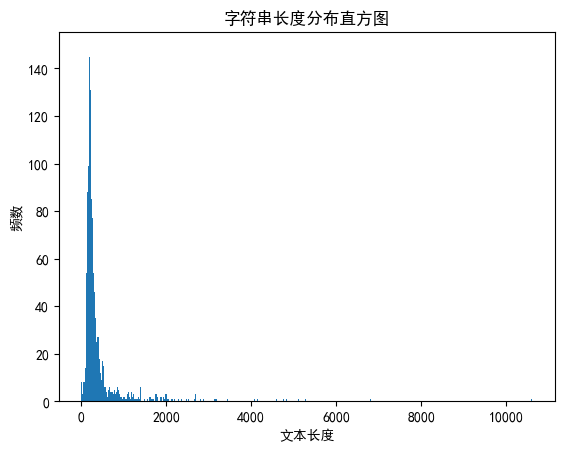

In [13]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False 

length_counts = data['Text'].apply(len).value_counts().sort_index()  

plt.hist(length_counts.index, bins=len(length_counts), weights=length_counts.values)  
plt.xlabel('文本长度')  
plt.ylabel('频数')  
plt.title('字符串长度分布直方图')  
plt.show()

In [14]:
length_counts

Text
5        1
8        1
12       3
16       1
22       1
        ..
5102     1
5285     1
6800     1
8471     1
10610    1
Name: count, Length: 506, dtype: int64

In [15]:
# Calculate the cumulative sum of counts
cumulative_counts = length_counts.cumsum()

# Calculate the percentage of texts shorter than 500
percentage_shorter_than_500 = cumulative_counts[500] / len(data) * 100

percentage_shorter_than_500

85.01102130786187

In [16]:
MAX_LENGTH = 500

### class definition

In [17]:
tokenizer = BertTokenizer.from_pretrained(BERT_PATH)

In [11]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.labels = [labels[i] for i in data['Generated']]
        self.texts = [tokenizer(text, 
                                padding='max_length',
                                max_length = MAX_LENGTH,
                                truncation=True,
                                return_tensors='pt')
                      for text in data['Text']]
    
    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        return np.array(self.labels[idx])
    
    def get_batch_texts(self, idx):
        return self.texts[idx]

    def __getitem__(self, idx):
        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

# Training
---

In [12]:
from torch import nn

## Model Class Definition

In [13]:
class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):
        super(BertClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(BERT_PATH)
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, len(labels))
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):
        _, pooled_output = self.bert(input_ids=input_id, 
                                     attention_mask=mask, 
                                     return_dict=False)
        
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)
        
        return final_layer

## Training Function Definition

In [14]:
from torch.optim import Adam
from tqdm import tqdm

In [22]:
def train(model, train_data, val_data, optimizer, epochs, BATCH_SIZE):

    train, val = Dataset(train_data), Dataset(val_data)
    train_dataloader = torch.utils.data.DataLoader(train, 
                                                   batch_size=BATCH_SIZE,  
                                                   shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=BATCH_SIZE)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()

    if(use_cuda):
        criterion = criterion.cuda()
        model = model.cuda()

        # load optimizer to cuda
        for state in optimizer.state.values():
            for k, v in state.items():
                if torch.is_tensor(v):
                    state[k] = v.cuda()

    total_loss_train = 0
    total_acc_train = 0
    total_acc_val = 0
    total_loss_val = 0


    for epoch_num in range(epochs):

        total_loss_train = 0
        total_acc_train = 0

        for train_input, train_label in tqdm(train_dataloader):

            train_label = train_label.to(device)
            mask = train_input['attention_mask'].to(device)
            input_id = train_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)

            batch_loss = criterion(output, train_label.long())
            total_loss_train += batch_loss.item()
            
            acc = (output.argmax(dim=1) == train_label).sum().item()
            total_acc_train += acc

            model.zero_grad()
            batch_loss.backward()
            optimizer.step()

        total_acc_val = 0
        total_loss_val = 0

        with torch.no_grad():

            for val_input, val_label in tqdm(val_dataloader):
                
                val_label= val_label.to(device)
                mask = val_input['attention_mask'].to(device)
                input_id = val_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)

                batch_loss = criterion(output, val_label.long())
                total_loss_val += batch_loss.item()

                acc = (output.argmax(dim=1) == val_label).sum().item()
                total_acc_val += acc

        print(f'''Epochs: {epoch_num + 1} 
        | Train Loss: {total_loss_train / len(train_data): .3f} 
        | Train Accuracy: {total_acc_train / len(train_data): .3f} 
        | Val Loss: {total_loss_val / len(val_data): .3f} 
        | Val Accuracy: {total_acc_val / len(val_data): .3f}''') 

    return total_loss_train, optimizer.state_dict()
    

## Defining Parameters

In [23]:
EPOCHS = 1
LR = 1e-6
BATCH_SIZE = 16

model = BertClassifier()

optimizer = Adam(model.parameters(), lr=LR)

df_train = pd.concat([X_train, y_train], axis=1)
df_val = pd.concat([X_val, y_val], axis=1)

## Training

In [24]:
loss = train(model,
        df_train,
        df_val,
        optimizer,
        EPOCHS,
        BATCH_SIZE)

100%|██████████| 9/9 [00:03<00:00,  2.92it/s]

Epochs: 1 
        | Train Loss:  0.037 
        | Train Accuracy:  0.774 
        | Val Loss:  0.027 
        | Val Accuracy:  0.818


## Save Current Model

In [25]:
torch.save({'epoch': EPOCHS,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss},
            'trained_1_epoch_model.pth')

## Retraining

In [26]:
RETRAIN_EPOCHS = 10

change the path here to the updated model path

In [27]:
load_path = 'trained_1_epoch_model.pth'

In [32]:
LR = 1e-6
BATCH_SIZE = 8

df_train = pd.concat([X_train, y_train], axis=1)
df_val = pd.concat([X_val, y_val], axis=1)

In [33]:
for epoch in range(RETRAIN_EPOCHS):
      
      # loading previous model
      load_model = BertClassifier()

      checkpoint = torch.load(load_path)
      load_model.load_state_dict(checkpoint['model_state_dict'])

      optimizer = Adam(load_model.parameters(), lr=LR)
      optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

      trained_epoch = checkpoint['epoch']

      # train
      loss = train(load_model, 
                   df_train,
                   df_val,
                   optimizer,
                   1, 
                   BATCH_SIZE)

      # save current model
      prefix = 'trained_' + str(trained_epoch + 1) + '_epoch_'
      save_path = prefix + 'model.pth'

      torch.save({'epoch': trained_epoch+1,
            'model_state_dict': load_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss},
            save_path)

      load_path = save_path
            

100%|██████████| 18/18 [00:02<00:00,  6.60it/s]


Epochs: 1 
        | Train Loss:  0.039 
        | Train Accuracy:  0.868 
        | Val Loss:  0.027 
        | Val Accuracy:  0.949


100%|██████████| 18/18 [00:02<00:00,  6.61it/s]


Epochs: 1 
        | Train Loss:  0.026 
        | Train Accuracy:  0.924 
        | Val Loss:  0.021 
        | Val Accuracy:  0.942


100%|██████████| 18/18 [00:02<00:00,  6.58it/s]


Epochs: 1 
        | Train Loss:  0.017 
        | Train Accuracy:  0.957 
        | Val Loss:  0.014 
        | Val Accuracy:  0.964


100%|██████████| 18/18 [00:02<00:00,  6.56it/s]


Epochs: 1 
        | Train Loss:  0.011 
        | Train Accuracy:  0.975 
        | Val Loss:  0.009 
        | Val Accuracy:  0.985


100%|██████████| 18/18 [00:02<00:00,  6.58it/s]


Epochs: 1 
        | Train Loss:  0.008 
        | Train Accuracy:  0.989 
        | Val Loss:  0.008 
        | Val Accuracy:  0.978


100%|██████████| 18/18 [00:02<00:00,  6.59it/s]


Epochs: 1 
        | Train Loss:  0.006 
        | Train Accuracy:  0.994 
        | Val Loss:  0.007 
        | Val Accuracy:  0.985


100%|██████████| 18/18 [00:02<00:00,  6.62it/s]


Epochs: 1 
        | Train Loss:  0.004 
        | Train Accuracy:  0.997 
        | Val Loss:  0.004 
        | Val Accuracy:  1.000


100%|██████████| 18/18 [00:02<00:00,  6.62it/s]


Epochs: 1 
        | Train Loss:  0.003 
        | Train Accuracy:  0.997 
        | Val Loss:  0.004 
        | Val Accuracy:  0.985


100%|██████████| 18/18 [00:02<00:00,  6.56it/s]


Epochs: 1 
        | Train Loss:  0.003 
        | Train Accuracy:  0.998 
        | Val Loss:  0.005 
        | Val Accuracy:  0.985


100%|██████████| 18/18 [00:02<00:00,  6.60it/s]


Epochs: 1 
        | Train Loss:  0.002 
        | Train Accuracy:  0.999 
        | Val Loss:  0.004 
        | Val Accuracy:  0.993


# Evaluation
---

## Evaluation Definition

In [37]:
def evaluate(model, test_data, BATCH_SIZE):

    test = Dataset(test_data)
    test_dataloader = torch.utils.data.DataLoader(test,
                                                  batch_size = BATCH_SIZE)
    use_cuda = (torch.cuda.is_available())
    device = torch.device('cuda' if use_cuda else 'cpu')
    if use_cuda:
        model = model.cuda()

    total_acc_test = 0

    with torch.no_grad():
        for test_input, test_label in test_dataloader:
            test_label = test_label.to(device)
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)    
            
            output = model(input_id, mask)
            acc = (output.argmax(dim=1) == test_label).sum().item()
            total_acc_test += acc

    print(f"test accuracy : {total_acc_test / len(test_data): .3f}")

## Loading Previous Model

reference: https://pytorch.org/tutorials/beginner/saving_loading_models.html

saving and loading a general checkpoint for inference and resuming training

In [34]:
load_model = BertClassifier()
checkpoint = torch.load('trained_11_epoch_model.pth')

load_model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

## Evaluating on Test Data

In [35]:
df_test = pd.read_csv('./data/test_data.csv')
X_test = df['Text']
y_test = df['Generated']
df_test = pd.concat([X_test, y_test], axis=1)

In [38]:
evaluate(load_model, df_test, BATCH_SIZE)

test accuracy :  0.998


# Exploratory Testing
---

In [25]:
load_model = BertClassifier()
checkpoint = torch.load('trained_11_epoch_model.pth')

load_model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [33]:
text_1 = "在实验过程中，我们使用了和一般题目给的滑动窗口不一样的想法。我们可以发现，数据呈现周期性（可以想到，只有在日照时光伏才会发电，故发电量和功率应该是周期性变化的，对应日出的时间）。这里我们通过限定时间长度来发现周期性这一事实"

In [42]:
test_data_1 = {'Text': text_1,
               'Generated': 0}
test_data_1 = pd.DataFrame(test_data_1, index=['0'])

In [43]:
X_1 = test_data_1.iloc[:,  :]
MAX_LENGTH = 512

evaluate(load_model, X_1, 1)

test accuracy :  1.000


In [46]:
text_2 = '在实验过程中，我们采用了与传统研究常规滑动窗口不同的方法。我们观察到数据呈现出明显的周期性，这可归因于光伏发电仅在白天发生的固有特性。因此，我们推断电力输出和功率应该呈现与日出时间相一致的周期性变化。为了系统地识别这种周期性，我们通过将分析限制在特定的时间间隔内来进行。'

test_data_2 = {'Text': text_2,
               'Generated': 0}
test_data_2 = pd.DataFrame(test_data_2, index=['0'])

X_2 = test_data_2.iloc[:, :]

evaluate(load_model, X_2, 1)

test accuracy :  1.000


In [56]:
text_3 = """"""

test_data_3 = {'Text': text_3,
               'Generated': 0}
test_data_3 = pd.DataFrame(test_data_3, index=['0'])

X_3 = test_data_3.iloc[:, :]

evaluate(load_model, X_3, 1)

test accuracy :  0.000


In [57]:
text_2 = """
在我们最近的实验中，我们试图探索在光伏数据分析中的新颖方法。与传统方法有所不同，我们采用了一种独特的方法，偏离了通常在类似研究中使用的标准滑动窗口技术。我们的实验方法涉及对光伏电池在不同条件下生成的数据进行检查。值得注意的是，我们将分析限制在特定的时间间隔内，采用了一种与常用的滑动窗口不同的策略。我们实验的主要观察是数据中存在明显的周期性。这种周期性可以合理地归因于光伏发电的固有特性，即仅在白天发生。我们推测，电力输出和电池生成的功率应该呈现出与日出时间相对应的周期性变化。在光伏数据中识别周期模式对于理解发电动态具有重要意义。认识到电力输出与白天小时的周期性关系可以为太阳能系统的更精确预测和优化提供信息。总的来说，我们的实验通过采用非传统的分析方法成功揭示了光伏数据中的独特周期性。这一发现有助于更深入地理解太阳能发电的时间动态，为太阳能系统的优化提供了有价值的信息。在这一领域的进一步研究可以涉及对已识别的周期模式及其对优化光伏系统的影响进行更详细的分析。此外，探讨实验参数的变化可能提供对所观察到的周期性更全面的理解。"""

test_data_2 = {'Text': text_2,
               'Generated': 0}
test_data_2 = pd.DataFrame(test_data_2, index=['0'])

X_2 = test_data_2.iloc[:, :]

evaluate(load_model, X_2, 1)

test accuracy :  1.000
